In [1]:
%matplotlib inline
from building_sensor_analysis_api import *

Read file:  506_0_3001981.csv
Std dev is  3.23596249551
Fitting piecewise_constant
range =  16.97
piecewise_linear model initialized
error = 0.0163576210903 error/_std= 0.00505494767415


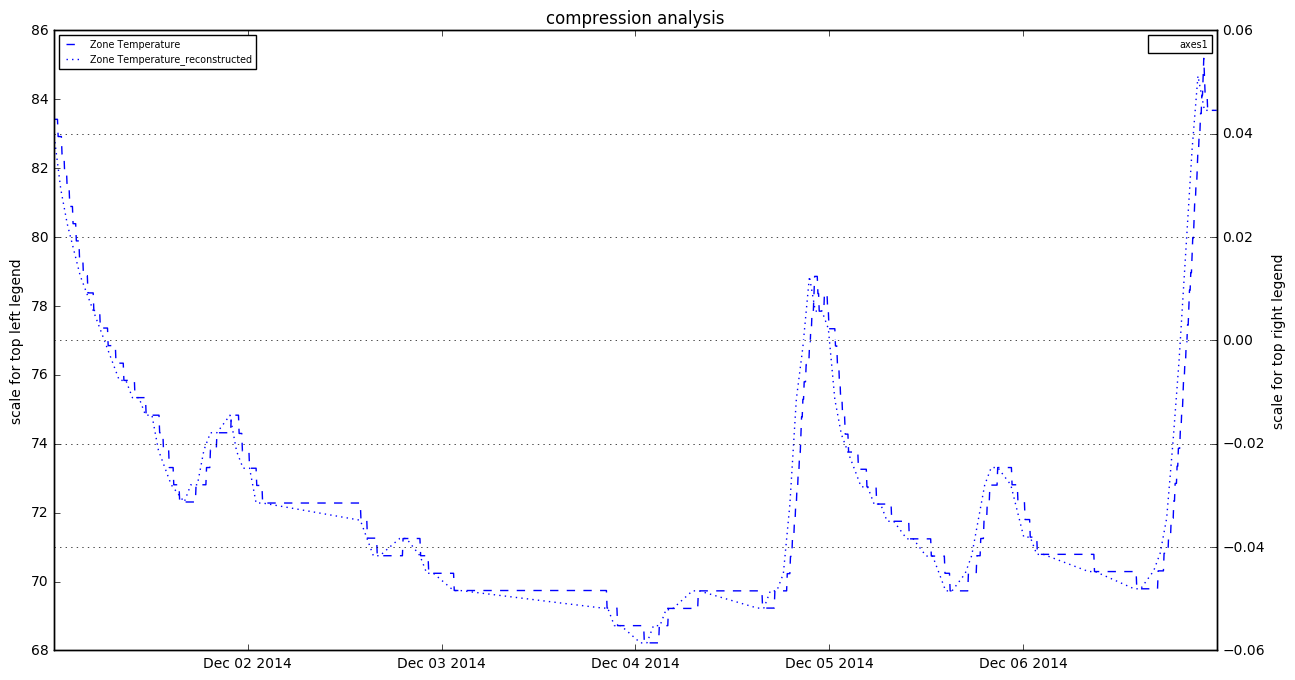

In [3]:
room = 'Rm-4226'
signals = ['Zone Temperature']
[dfs, plotTemplates] = runAnalysis(room, stTime='2014-12-01', enTime='2014-12-07',
                                   templates = signals)
plotResults(dfs, plotTemplates)

Read file:  506_0_3001981.csv
Std dev is  3.23596249551
Fitting piecewise_constant
range =  16.97
piecewise_constant model initialized
error = 0.00515153738704 error/_std= 0.00159196449099


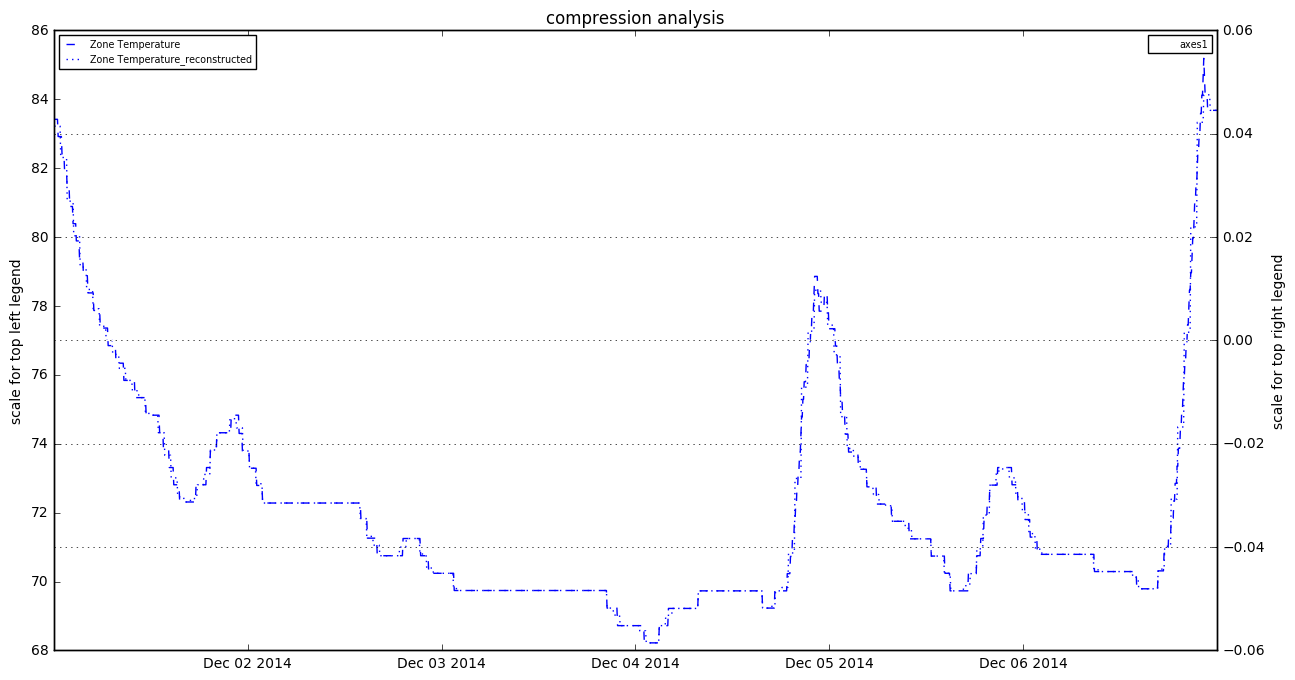

In [4]:
room = 'Rm-4226'
signals = ['Zone Temperature']
[dfs, plotTemplates] = runAnalysis(room, stTime='2014-12-01', enTime='2014-12-07',
                                   templates = signals, method='piecewise_constant')
plotResults(dfs, plotTemplates)